In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

在相同的attention mechanism之下, 捕捉不同範圍內seq的相關性  
`架構運作流程為: ` 將query, key, value做linear projection -> 將feature依照num_head分成不同的head -> 將結果去做attention pooling -> 將結果concat -> 做最後的linear projection  
`公式: `Before providing the implementation of multi-head attention,
let's formalize this model mathematically.
Given a query $\mathbf{q} \in \mathbb{R}^{d_q}$,
a key $\mathbf{k} \in \mathbb{R}^{d_k}$,
and a value $\mathbf{v} \in \mathbb{R}^{d_v}$,
each attention head $\mathbf{h}_i$  ($i = 1, \ldots, h$)
is computed as

$$\mathbf{h}_i = f(\mathbf W_i^{(q)}\mathbf q, \mathbf W_i^{(k)}\mathbf k,\mathbf W_i^{(v)}\mathbf v) \in \mathbb R^{p_v},$$

where learnable parameters
$\mathbf W_i^{(q)}\in\mathbb R^{p_q\times d_q}$,
$\mathbf W_i^{(k)}\in\mathbb R^{p_k\times d_k}$
and $\mathbf W_i^{(v)}\in\mathbb R^{p_v\times d_v}$,
and
$f$ is attention pooling,
such as
additive attention and scaled dot-product attention
in :numref:`sec_attention-scoring-functions`.
The multi-head attention output
is another linear transformation via 
learnable parameters
$\mathbf W_o\in\mathbb R^{p_o\times h p_v}$
of the concatenation of $h$ heads:

$$\mathbf W_o \begin{bmatrix}\mathbf h_1\\\vdots\\\mathbf h_h\end{bmatrix} \in \mathbb{R}^{p_o}.$$
***
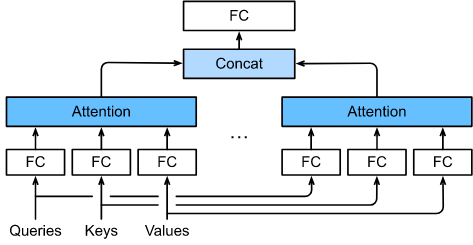
`reference: ` https://d2l.ai/chapter_attention-mechanisms-and-transformers/multihead-attention.html

In [2]:
class MultiHeadAttention(d2l.Module):  #@save
    """Multi-head attention."""
    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout, num_heads)
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens, window_mask=None):
        # Shape of queries, keys, or values:
        # (batch_size, no. of queries or key-value pairs, num_hiddens)
        # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
        # After transposing, shape of output queries, keys, or values:
        # (batch_size * num_heads, no. of queries or key-value pairs,
        # num_hiddens / num_heads)
        queries = self.transpose_qkv(self.W_q(queries))
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))

        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for num_heads
            # times, then copy the next item, and so on
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # Shape of output: (batch_size * num_heads, no. of queries,
        # num_hiddens / num_heads)
        output = self.attention(queries, keys, values, valid_lens,
                                window_mask)
        # Shape of output_concat: (batch_size, no. of queries, num_hiddens)
        output_concat = self.transpose_output(output)
        return self.W_o(output_concat)

transpose_qkv -> 將input data切分成muti-head  
transpose_output -> 將muti-head output進行還原

In [3]:
@d2l.add_to_class(MultiHeadAttention)  #@save
def transpose_qkv(self, X):
    """Transposition for parallel computation of multiple attention heads."""
    # Shape of input X: (batch_size, no. of queries or key-value pairs,
    # num_hiddens). Shape of output X: (batch_size, no. of queries or
    # key-value pairs, num_heads, num_hiddens / num_heads)
    X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
    # Shape of output X: (batch_size, num_heads, no. of queries or key-value
    # pairs, num_hiddens / num_heads)
    X = X.permute(0, 2, 1, 3)
    # Shape of output: (batch_size * num_heads, no. of queries or key-value
    # pairs, num_hiddens / num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])

@d2l.add_to_class(MultiHeadAttention)  #@save
def transpose_output(self, X):
    """Reverse the operation of transpose_qkv."""
    X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [4]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_heads, 0.5)

/Users/welcome870117/opt/anaconda3/envs/trading/lib/python3.7/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [5]:
batch_size, num_queries, num_kvpairs, valid_lens = 2, 4, 6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
d2l.check_shape(attention(X, Y, Y, valid_lens),
                (batch_size, num_queries, num_hiddens))